```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from matplotlib import animation, rc, colors, colorbar
from matplotlib import pyplot as plt

from IPython.display import clear_output
from IPython.display import Video

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
import re

def tex_escape(text):
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities

In [4]:
%setup_logging -o lofoten_sim.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger using level DEBUG to lofoten_sim.log
Python version 3.7.2 (default, Mar 13 2019, 14:18:46) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]
Registering gpu_ctx in user workspace
PyCUDA version 2018.1.1
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <31601664>


In [5]:
#Set this to false before comitting to only get images
create_movie = False
movie_frames = None 

# Select area and result folder

In [6]:


#case = 1 # Open waters in the Norwegian Sea
#case = 2 # Lofoten
case = 3 # The Norwegian Coast

casename = 'norwegian_sea_'


if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'
    
folder = casename+datetime.datetime.now().strftime("%Y_%m_%d")

# Overrule the above folder name:
#folder = 'norwegian_sea_2019_10_09'
#folder = 'lofoten_2019_10_07'
#folder = 'complete_coast_2019_10_09'


assert(folder.startswith(casename)), 'folder does not start with casename!'


os.makedirs(folder, exist_ok=True)
print(folder)

complete_coast_2019_10_16


# Misc helper functions

In [7]:
def printInfo(url):
    try:
        ncfile = Dataset(url)
        print("Variables")
        for var in ncfile.variables:
            print(var)

        print ("Attributes:")    
        for attr in ncfile.ncattrs():
            print(attr, ": ", ncfile.getncattr(attr))
    
    except Exception as e:
        raise e
        
    finally:
        ncfile.close()

In [8]:
def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.05, uv_max=0.05, 
                 add_extra=0,
                 ax=None, sp=None,
                 rotate=False, downsample=None):
    if (plt.rcParams["text.usetex"]):
        comment = tex_escape(comment)
    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    x_plots = 1
    y_plots = 1
    
    if (downsample is not None):
        eta = eta[::downsample, ::downsample]
        h = h[::downsample, ::downsample]
        hu = hu[::downsample, ::downsample]
        hv = hv[::downsample, ::downsample]
    
    if (add_extra == 1):
        x_plots=3
        y_plots=1
    elif (add_extra == 2):
        x_plots=3
        y_plots=2
        
    if (add_extra == 2):
        V_max = 3 * (uv_max-uv_min) / np.max(h)
        R_min = -V_max/2000
        R_max = V_max/2000
        
        V = PlotHelper.genVelocity(h, hu, hv)
        #FIXME: Check curl and dx / dy!
        R = PlotHelper.genColors(h, hu/dy, hv/dx, plt.cm.seismic, R_min, R_max)
            
    ny, nx = eta.shape
    if (rotate):
        domain_extent = [0, ny*dy/1000, 0, nx*dx/1000]
        eta = np.rot90(eta, 3)
        h = np.rot90(h, 3)
        hu = np.rot90(hu, 3)
        hv = np.rot90(hv, 3)
        
        if (add_extra == True):
            V = np.rot90(V, 3)
            R = np.rot90(R, 3)
    else:
        domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]
    
    

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        if (add_extra > 0):
            ax[1] = plt.subplot(y_plots, x_plots, 2)
            sp[1] = ax[1].imshow(hu, interpolation="none", origin='bottom', 
                                 cmap=plt.cm.coolwarm, 
                                 vmin=uv_min, vmax=uv_max, 
                                 extent=domain_extent)
            plt.colorbar(sp[1], shrink=0.9)
            plt.axis('image')
            plt.title("$hu$")

            ax[2] = plt.subplot(y_plots, x_plots, 3)
            sp[2] = ax[2].imshow(hv, interpolation="none", origin='bottom', 
                                 cmap=plt.cm.coolwarm, 
                                 vmin=uv_min, vmax=uv_max, 
                                 extent=domain_extent)
            plt.colorbar(sp[2], shrink=0.9)
            plt.axis('image')
            plt.title("$hv$")

        if (add_extra > 1):
            ax[3] = plt.subplot(y_plots, x_plots, 4)
            sp[3] = ax[3].imshow(V, interpolation="none", origin='bottom', 
                               cmap=plt.cm.Oranges, 
                               vmin=0, vmax=V_max, 
                               extent=domain_extent)
            plt.colorbar(sp[3], shrink=0.9)
            plt.axis('image')
            plt.title("Particle velocity magnitude")

            ax[4] = plt.subplot(y_plots, x_plots, 5)
            sp[4] = ax[4].imshow(R, interpolation="none", 
                               origin='bottom', 
                               extent=domain_extent)
            sm = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=R_min, vmax=R_max), cmap=plt.cm.seismic)
            sm.set_array([])
            fig.colorbar(sm, shrink=0.9)
            #colorbar.Colorbar(ax[4], cmap=plt.cm.seismic, mappable=plt.cm.ScalarMappable(norm=colors.Normalize(vmin=R_min, vmax=R_max), cmap=plt.cm.seismic)colors.Normalize(vmin=R_min, vmax=R_max), orientation='horizontal', shrink=0.9)
            plt.axis('image')
            plt.title("Vorticity magnitude")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        if (add_extra > 0):
            fig.sca(ax[1])
            sp[1].set_data(hu)

            fig.sca(ax[2])
            sp[2].set_data(hv)
        
        if (add_extra > 1):
            fig.sca(ax[3])
            sp[3].set_data(V)

            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

# Inspect URL and select area

In [9]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

local_norkyst800_url_havahol = '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/cdklm_practicalities/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

if source_url == norkyst800_url and os.path.exists(local_norkyst800_url_havahol):
    source_url = local_norkyst800_url_havahol

In [10]:
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    print(H_full.shape)
    lat = np.array(ncfile.variables["lat"])
    lon = np.array(ncfile.variables["lon"])
except Exception as e:
    raise e

finally:
    ncfile.close()

(902, 2602)


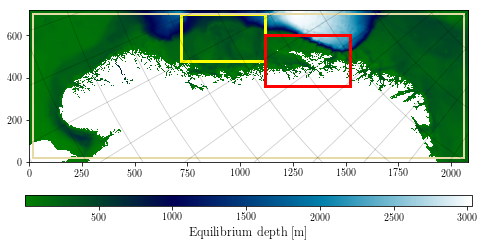

In [11]:
##### 
case2_x0 = 1400
case2_x1 = int(case2_x0 + 500)
case2_y0 = 450
case2_y1 = int(case2_y0 + 300)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875


land_value = H_full.min()
(full_ny, full_nx) = H_full.shape

# Makes sure axis are in km (assuming equidistant 800x800m grid)
extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


fig = plt.figure(figsize=(8,4))

# Land and bathymetry
land = np.ma.masked_where(H_full == land_value, H_full)
im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
           extent=extent)

cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
cbar.set_label('Equilibrium depth [m]', size=12.5)


# Case boxes
fig.gca().fill(np.array([case1_x0, case1_x0, case1_x1, case1_x1])*0.8, 
               np.array([case1_y0, case1_y1, case1_y1, case1_y0])*0.8, 
               fill=False, linestyle='-', linewidth=3, color='yellow')
fig.gca().fill(np.array([case2_x0, case2_x0, case2_x1, case2_x1])*0.8, 
               np.array([case2_y0, case2_y1, case2_y1, case2_y0])*0.8, 
               fill=False, linestyle='-', linewidth=3, color='red')

# Save without north arrow
plt.savefig(os.path.join(folder, 'caseLocationsInNorway.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway.png'))

plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN.png'))

fig.gca().fill(np.array([case3_x0, case3_x0, case3_x1, case3_x1])*0.8, 
               np.array([case3_y0, case3_y1, case3_y1, case3_y0])*0.8, 
               fill=False, linestyle='-', linewidth=2, color='xkcd:beige')

plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases.png'))

plt.contour(lon, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
plt.contour(lat, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.pdf'))
plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.png'))




In [12]:
## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

else:

    print('using Norwegian Sea area')


using the complete coast case


In [13]:
H_full = None

# Get initial conditions

In [14]:



try:
    ncfile = Dataset(source_url)
    #H_i_orig = ncfile.variables['h'][y0-border_size:y1+border_size+1, x0-border_size:x1+border_size+1]
    H_i_orig = ncfile.variables['h'][y0:y1+1, x0:x1+1]
except Exception as e:
    raise e
finally:
    ncfile.close()
    

Read Hm as (852, 2552)
Completed in 100 iterations
(850, 2550)
(851, 2551)


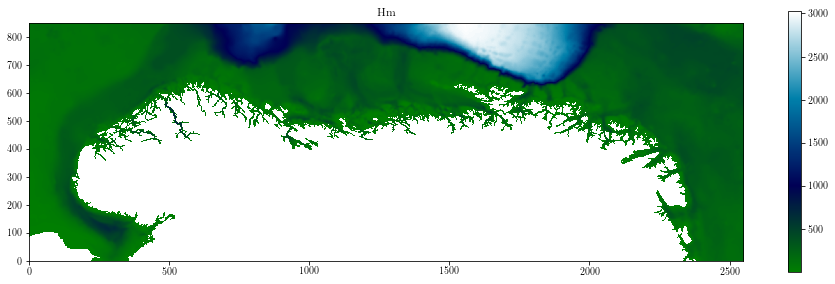

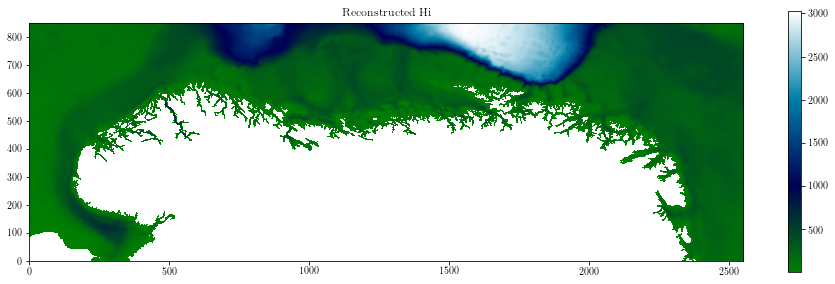

In [15]:


try:
    ncfile = Dataset(source_url)
    H_m = ncfile.variables['h'][y0-1:y1+1, x0-1:x1+1]
    print("Read Hm as " + str(H_m.shape))

except Exception as e:
    raise e
finally:
    ncfile.close()

#Apply land mask
from scipy.ndimage.morphology import binary_erosion
H_m = np.ma.array(H_m, mask = (H_m == land_value))
H_m.mask = binary_erosion(H_m.mask)
H_m.fill_value = land_value

H_i, convergence = OceanographicUtilities.midpointsToIntersections(H_m, 100)
H_m = OceanographicUtilities.intersectionsToMidpoints(H_i)

print("Completed in " + str(len(convergence)) + " iterations")

fig = plt.figure(figsize=(16,8))
plt.imshow(H_m, interpolation="None", origin='lower', cmap='ocean')
plt.colorbar(shrink=0.6)
plt.title("Hm")

fig = plt.figure(figsize=(16,8))
plt.imshow(H_i, interpolation="None", origin='lower', cmap='ocean')
plt.colorbar(shrink=0.6)
plt.title("Reconstructed Hi")


print(H_m.shape)
print(H_i.shape)

[0.92100006, -1.588]
[442.2672013133021, -363.95278391812496]
[333.3361798490359, -275.6964227721991]


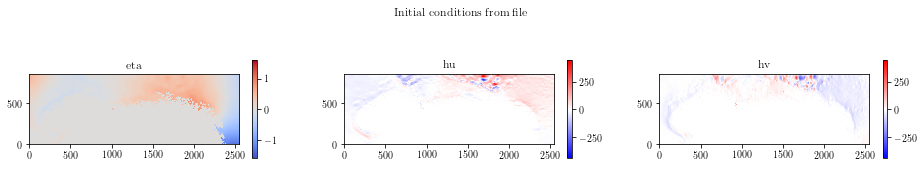

In [16]:
try:
    ncfile = Dataset(source_url)
    eta0 = ncfile.variables['zeta'][0, y0:y1, x0:x1]
    u0 = ncfile.variables['ubar'][0, y0:y1, x0:x1]
    v0 = ncfile.variables['vbar'][0, y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

eta0 = eta0.filled(0)
u0 = u0.filled(0)
v0 = v0.filled(0)

hu0 = (H_m+eta0)*u0
hv0 = (H_m+eta0)*v0

u0 = None
v0 = None

etamax = np.max(np.abs(eta0))
uvmax = max(np.max(np.abs(hu0)), np.max(np.abs(hv0)))
    
plt.figure(figsize=(16, 3))
plt.suptitle("Initial conditions from file")

plt.subplot(1,3,1)
plt.title("eta")
plt.imshow(eta0, interpolation="None", origin='lower', cmap='coolwarm', vmin=-etamax, vmax=etamax)
plt.colorbar(shrink=0.6)

plt.subplot(1,3,2)
plt.title("hu")
plt.imshow(hu0, interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
plt.colorbar(shrink=0.6)

plt.subplot(1,3,3)
plt.title("hv")
plt.imshow(hv0, interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
plt.colorbar(shrink=0.6)

for var in [eta0, hu0, hv0]:
    print([np.max(var), np.min(var)])

# Get timesteps

In [17]:
timesteps = list(range(0,24))
#timesteps = list(range(0,2))

try:
    ncfile = Dataset(source_url)
    time_var = ncfile.variables['time']
    print(time_var.shape)
    time = time_var[timesteps]
except Exception as e:
    raise e
finally:
    ncfile.close()

time = time - time[0]
print(time)
print(time/3600)

(24,)
[    0.  3600.  7200. 10800. 14400. 18000. 21600. 25200. 28800. 32400.
 36000. 39600. 43200. 46800. 50400. 54000. 57600. 61200. 64800. 68400.
 72000. 75600. 79200. 82800.]
[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0
 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0]


# Get boundary conditions

In [18]:
try:
    ncfile = Dataset(source_url)
    
    H = ncfile.variables['h'][y0-1:y1+1, x0-1:x1+1]
    
    nt = len(time)
    
    bc_eta = {}
    bc_eta['north'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_eta['south'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_eta['east'] = np.empty((nt, y1-y0), dtype=np.float32)
    bc_eta['west'] = np.empty((nt, y1-y0), dtype=np.float32)
    
    bc_hu = {}
    bc_hu['north'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hu['south'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hu['east'] = np.empty((nt, y1-y0), dtype=np.float32)
    bc_hu['west'] = np.empty((nt, y1-y0), dtype=np.float32)
    
    bc_hv = {}
    bc_hv['north'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hv['south'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hv['east'] = np.empty((nt, y1-y0), dtype=np.float32)
    bc_hv['west'] = np.empty((nt, y1-y0), dtype=np.float32)
    
    progress = Common.ProgressPrinter()
    
    for timestep in range(len(timesteps)):        
        zeta = ncfile.variables['zeta'][timestep, y0-1:y1+1, x0-1:x1+1]
        zeta = zeta.filled(0)
        bc_eta['north'][timestep] = zeta[-1, 1:-1]
        bc_eta['south'][timestep] = zeta[0, 1:-1]
        bc_eta['east'][timestep] = zeta[1:-1, -1]
        bc_eta['west'][timestep] = zeta[ 1:-1, 0]

        h = H + zeta
        
        hu = ncfile.variables['ubar'][timestep, y0-1:y1+1, x0-1:x1+1]
        hu = hu.filled(0) #zero on land
        hu = h*hu
        
        bc_hu['north'][timestep] = hu[-1, 1:-1]
        bc_hu['south'][timestep] = hu[0, 1:-1]
        bc_hu['east'][timestep] = hu[1:-1, -1]
        bc_hu['west'][timestep] = hu[1:-1, 0]

        hv = ncfile.variables['vbar'][timestep, y0-1:y1+1, x0-1:x1+1]
        hv = hv.filled(0) #zero on land
        hv = h*hv
        
        bc_hv['north'][timestep] = hv[-1, 1:-1]
        bc_hv['south'][timestep] = hv[0, 1:-1]
        bc_hv['east'][timestep] = hv[1:-1, -1]
        bc_hv['west'][timestep] = hv[1:-1, 0]
        
        clear_output(wait = True)
        print(progress.getPrintString(timestep / (len(timesteps)-1)))
except Exception as e:
    raise e
finally:
    ncfile.close()

print("Done")

0% [##############################] 100%. Total: 18s, elapsed: 18s, remaining: 0s
Done


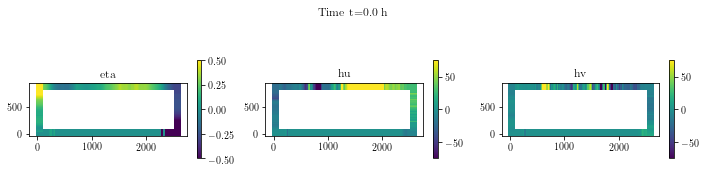

In [19]:
def bcAnimation(create_movie=True, **kwargs):
    nx = x1-x0
    ny = y1-y0
    x_north = np.linspace(x0, x1, nx)
    y_north = np.linspace(y1, y1, nx)

    x_south = np.linspace(x0, x1, nx)
    y_south = np.linspace(y0, y0, nx)

    x_east = np.linspace(x1, x1, ny)
    y_east = np.linspace(y0, y1, ny)

    x_west = np.linspace(x0, x0, ny)
    y_west = np.linspace(y0, y1, ny)
    
    fig = plt.figure(figsize=(12,3))
    
    sc = [None]*12
    ax = [None]*3
    
    plt.suptitle("Time t=" + str(time[0]/3600) + " h")
    ax[0] = plt.subplot(1,3,1)
    plt.title("eta")
    sc[0] = plt.scatter(x_north, y_north, c=bc_eta['north'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[1] = plt.scatter(x_south, y_south, c=bc_eta['south'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[2] = plt.scatter(x_east, y_east, c=bc_eta['east'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[3] = plt.scatter(x_west, y_west, c=bc_eta['west'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    ax[1] = plt.subplot(1,3,2)
    plt.title("hu")
    sc[4] = plt.scatter(x_north, y_north, c=bc_hu['north'][0,:], marker='s', vmax=75, vmin=-75)
    sc[5] = plt.scatter(x_south, y_south, c=bc_hu['south'][0,:], marker='s', vmax=75, vmin=-75)
    sc[6] = plt.scatter(x_east, y_east, c=bc_hu['east'][0,:], marker='s', vmax=75, vmin=-75)
    sc[7] = plt.scatter(x_west, y_west, c=bc_hu['west'][0,:], marker='s', vmax=75, vmin=-75)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    ax[2] = plt.subplot(1,3,3)
    plt.title("hv")
    sc[8] = plt.scatter(x_north, y_north, c=bc_hv['north'][0,:], marker='s', vmax=75, vmin=-75)
    sc[9] = plt.scatter(x_south, y_south, c=bc_hv['south'][0,:], marker='s', vmax=75, vmin=-75)
    sc[10] = plt.scatter(x_east, y_east, c=bc_hv['east'][0,:], marker='s', vmax=75, vmin=-75)
    sc[11] = plt.scatter(x_west, y_west, c=bc_hv['west'][0,:], marker='s', vmax=75, vmin=-75)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    #Helper function which simulates and plots the solution
    def animate(i):
        fig.suptitle("Time = {:04.0f} h".format(time[i]/3600), fontsize=18)
        
        fig.sca(ax[0])
        sc[0].set_array(bc_eta['north'][i])
        sc[1].set_array(bc_eta['south'][i])
        sc[2].set_array(bc_eta['east'][i])
        sc[3].set_array(bc_eta['west'][i])
        
        fig.sca(ax[1])
        sc[4].set_array(bc_hu['north'][i])
        sc[5].set_array(bc_hu['south'][i])
        sc[6].set_array(bc_hu['east'][i])
        sc[7].set_array(bc_hu['west'][i])
        
        fig.sca(ax[2])
        sc[8].set_array(bc_hv['north'][i])
        sc[9].set_array(bc_hv['south'][i])
        sc[10].set_array(bc_hv['east'][i])
        sc[11].set_array(bc_hv['west'][i])

    #Matplotlib for creating an animation
    if (create_movie):
        anim = animation.FuncAnimation(fig, animate, range(len(time)), interval=250)
        plt.close(fig)
        return anim
    else:
        pass
        
bcAnimation(create_movie=create_movie)

In [20]:
sponge_cells=[80, 80, 80, 80]
bc = Common.BoundaryConditions(north=3, south=3, east=3, west=3, spongeCells=sponge_cells)
bc_data = Common.BoundaryConditionsData(time, 
            north=Common.SingleBoundaryConditionData(bc_eta['north'], bc_hu['north'], bc_hv['north']),
            south=Common.SingleBoundaryConditionData(bc_eta['south'], bc_hu['south'], bc_hv['south']),
            east=Common.SingleBoundaryConditionData(bc_eta['east'], bc_hu['east'], bc_hv['east']),
            west=Common.SingleBoundaryConditionData(bc_eta['west'], bc_hu['west'], bc_hv['west']))

# Get wind forcing

In [21]:
try:
    ncfile = Dataset(source_url)
    u_wind = ncfile.variables['Uwind'][timesteps, y0:y1, x0:x1]
    v_wind = ncfile.variables['Vwind'][timesteps, y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

u_wind = u_wind.filled(0)
v_wind = v_wind.filled(0)
    
print(u_wind.shape)
print(v_wind.shape)

(24, 850, 2550)
(24, 850, 2550)


Text(0, 0.5, '$C_D$')

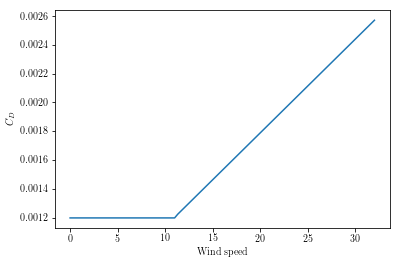

In [22]:
def computeDrag(wind_speed):
    C_drag = np.where(wind_speed < 11, 0.0012, 0.00049 + 0.000065*wind_speed)
    return C_drag

wind_speed = np.linspace(0, 32, 100)
C_drag = computeDrag(wind_speed)

fig = plt.figure()
plt.plot(wind_speed, C_drag, label='Drag coefficient $C_D$')
plt.xlabel("Wind speed")
plt.ylabel("$C_D$")

In [23]:
wind_speed = np.sqrt(np.power(u_wind, 2) + np.power(v_wind, 2))

# C_drag as defined by Engedahl (1995)
#(See "Documentation of simple ocean models for use in ensemble predictions. Part II: Benchmark cases"
#at https://www.met.no/publikasjoner/met-report/met-report-2012 for details.) /
C_drag = computeDrag(wind_speed)

rho_a = 1.225 # Density of air
rho_w = 1025 # Density of water

#Wind stress is then 
# tau_s = rho_a * C_drag * |W|W
wind_stress = C_drag * wind_speed * rho_a / rho_w
wind_stress_u = wind_stress*u_wind
wind_stress_v = wind_stress*v_wind

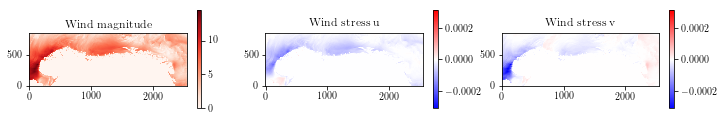

In [24]:
def animateWind(create_movie=True):
    max_speed = np.max(wind_speed)
    max_stress = max(np.max(np.abs(wind_stress_u)), np.max(np.abs(wind_stress_v)))

    fig = plt.figure(figsize=(12,3))
    
    ax = [None]*3
    sc = [None]*3
    
    ax[0] = plt.subplot(1,3,1)
    plt.title("Wind magnitude")
    sc[0] = plt.imshow(wind_speed[0], origin='lower', vmin=0, vmax=max_speed, cmap='Reds')
    plt.colorbar(shrink=0.6)

    ax[1] = plt.subplot(1,3,2)
    plt.title("Wind stress u")
    sc[1] = plt.imshow(wind_stress_u[0], origin='lower', cmap='bwr', vmin=-max_stress, vmax=max_stress)
    plt.colorbar(shrink=0.6)

    ax[2] = plt.subplot(1,3,3)
    plt.title("Wind stress v")
    sc[2] = plt.imshow(wind_stress_v[0], origin='lower', cmap='bwr', vmin=-max_stress, vmax=max_stress)
    plt.colorbar(shrink=0.6)
    
    
    #Helper function which simulates and plots the solution
    def animate(i):
        fig.suptitle("Time = {:04.0f} h".format(time[i]/3600), fontsize=18)
        
        fig.sca(ax[0])
        sc[0].set_data(wind_speed[i])
        
        fig.sca(ax[1])
        sc[1].set_data(wind_stress_u[i])
        
        fig.sca(ax[2])
        sc[2].set_data(wind_stress_v[i])

    #Matplotlib for creating an animation
    if (create_movie):
        anim = animation.FuncAnimation(fig, animate, range(len(time)), interval=250)
        plt.close(fig)
        return anim
    else:
        pass
    
animateWind(create_movie=create_movie)

In [25]:
wind_source = WindStress.WindStress(t=time, X=wind_stress_u, Y=wind_stress_v)

# Get domain size

In [26]:
try:
    Dataset(source_url)
    x = ncfile.variables['X'][x0:x1]
    y = ncfile.variables['Y'][y0:y1]
except Exception as e:
    raise e
finally:
    ncfile.close()

nx = x1 - x0 - sponge_cells[1] - sponge_cells[3]
ny = y1 - y0 - sponge_cells[0] - sponge_cells[2]

dx = np.average(x[1:] - x[:-1])
dy = np.average(y[1:] - y[:-1])

print("Domain size: " + str([nx, ny]))
print("Cell size: " + str([dx, dy]))

Domain size: [2390, 690]
Cell size: [800.0, 800.0]


# Get Coriolis parameters

In [27]:
try:
    ncfile = Dataset(source_url)
    angle = ncfile.variables['angle'][y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

(-2.5, 52.5, -0.8, 16.8)

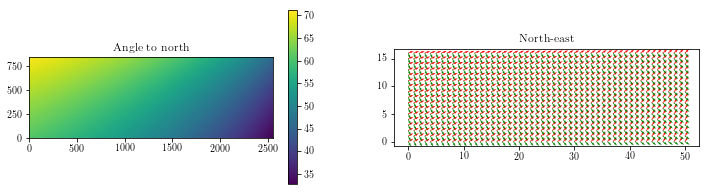

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Angle to north")
plt.imshow(angle*180/np.pi, origin='lower')
plt.axis('image')
plt.colorbar(shrink=0.4)

plt.subplot(1,2,2)
plt.title("North-east")
plt.quiver(np.sin(angle[::50, ::50]), np.cos(angle[::50, ::50]), color='r')
plt.quiver(np.cos(angle[::50, ::50]), -np.sin(angle[::50, ::50]), color='g')
plt.axis('image')

In [29]:
try:
    ncfile = Dataset(source_url)
    lat = ncfile.variables["lat"][y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

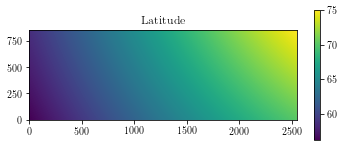

In [30]:
plt.figure()
plt.title("Latitude")
plt.imshow(lat, origin='lower')
plt.colorbar(shrink=0.6)

In [31]:
max_lat = np.max(lat)
min_lat = np.min(lat)
max_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(max_lat))
min_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(min_lat))
print("Max latitude: " + str(max_lat) + " => " + str(max_cor))
print("Min latitude: " + str(min_lat) + " => " + str(min_cor))

Max latitude: 75.02715673393767 => [0.00014089042949755784, 5.914277335636927e-12]
Min latitude: 56.14792340020126 => [0.00012111864605220386, 1.2751730058827873e-11]


In [32]:
f, beta = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat[0, 0]))
print("F and beta are " + str([f, beta]))

F and beta are [0.00012111864605220386, 1.2751730058827873e-11]


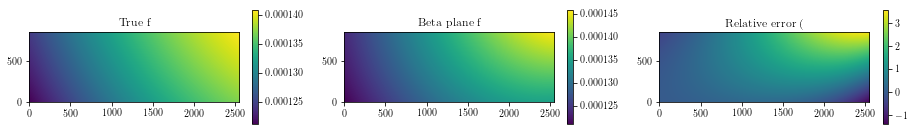

In [33]:
f_truth, _ = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat))

#Calculate beta plane approximation
YY, XX = np.mgrid[0:(y1-y0), 0:(x1-x0)]
XX = XX*dx
YY = YY*dy
local_lat = np.sin(angle)*XX + np.cos(angle)*YY
f_beta = f + beta*local_lat

plt.figure(figsize=(16, 3))
plt.subplot(1,3,1)
plt.title("True f")
plt.imshow(f_truth, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)


plt.subplot(1,3,2)
plt.title("Beta plane f")
plt.imshow(f_beta, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Relative error (%)")
plt.imshow(100*(f_beta-f_truth) / f_truth, origin='lower')#, vmin=-0.0001, vmax=0.0)
plt.colorbar(shrink=0.7)



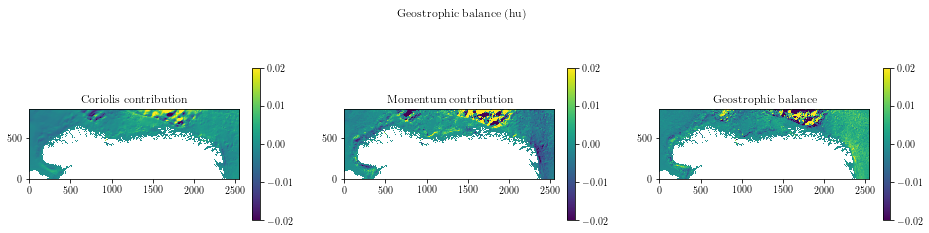

In [34]:
geos, geos_x, geos_y = OceanographicUtilities.calcGeostrophicBalance(
                            eta0, 
                            H_m, 
                            hu0, hv0, 
                            angle, f_beta,
                            dx, dy,
                            use_minmod=True)

plt.figure(figsize=(16,4))
plt.suptitle("Geostrophic balance (hu)")
plt.subplot(1,3,1)
plt.title("Coriolis contribution")
plt.imshow(geos_x[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,2)
plt.title("Momentum contribution")
plt.imshow(geos_x[1], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Geostrophic balance")
plt.imshow(geos[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

# Helpers for plotting and running simulation

In [35]:
def ncSimulation(sim, filename, timesteps, interior_domain_only, num_substeps = 3):
    filename = os.path.join(folder, filename)
    if (os.path.isfile(filename)):
        print("File " + filename + " already exists, skipping simulation.")
        return
    
    try:
        ncfile = Dataset(filename, 'w')

        var = {}
        var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
        _, var['Hm'] = sim.downloadBathymetry(interior_domain_only=interior_domain_only)

        ny, nx = var['eta'].shape

        # Create dimensions
        ncfile.createDimension('time', None) # unlimited
        ncfile.createDimension('x', nx)
        ncfile.createDimension('y', ny)

        ncvar = {}

        # Create variables for dimensions
        ncvar['time'] = ncfile.createVariable('time', 'f8', ('time',))
        ncvar['x'] = ncfile.createVariable('x', 'f4', ('x',))
        ncvar['y'] = ncfile.createVariable('y', 'f4', ('y',))

        # Fill dimension variables
        ncvar['x'][:] = np.linspace(0, nx*sim.dx, nx)
        ncvar['y'][:] = np.linspace(0, ny*sim.dy, ny)

        # Create static variables
        ncvar['Hm'] = ncfile.createVariable('Hm', 'f8', ('y', 'x',), zlib=True)
        ncvar['Hm'][:,:] = var['Hm'][:,:]

        # Create time varying data variables
        for varname in ['eta', 'hu', 'hv']:
            ncvar[varname] = ncfile.createVariable(varname, 'f8', ('time', 'y', 'x',), zlib=True)
        ncvar['num_iterations'] = ncfile.createVariable('num_iterations', 'i4', ('time',))

        #Simulate n timesteps
        timestep_sizes = timesteps[1:] - timesteps[:-1]
        timestep_sizes = np.insert(timestep_sizes, 0, 0)

        with Common.ProgressPrinter(5) as progress:
            for i, timestep_size in enumerate(timestep_sizes):
                #Don't simulate if first step (store initial conditions also)
                if (timestep_size > 0):
                    substep_size = timestep_size / num_substeps
                    for j in range(num_substeps):
                        sim.updateDt()
                        sim.step(substep_size)

                var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=False)
                ncvar['time'][i] = sim.t
                ncvar['num_iterations'][i] = sim.num_iterations

                abort=False
                for varname in ['eta', 'hu', 'hv']:
                    ncvar[varname][i,:,:] = var[varname][:,:] #np.ma.masked_invalid(var[varname][:,:])
                    if (np.any(np.isnan(var[varname]))):
                        print("Variable " + varname + " contains NaN values!")
                        abort=True

                if (abort):
                    print("Aborting at t=" + str(sim.t))
                    ncfile.sync()
                    break

                clear_output(wait = True)
                print(progress.getPrintString(i/(len(timestep_sizes)-1)))

    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

In [36]:
def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, save_movie=True, **kwargs):
    title = filename.replace('_', ' ').replace('.nc', '')
    filename = os.path.join(folder, filename)

    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))

    try:
        ncfile = Dataset(filename)
        x = ncfile.variables['x'][:]
        y = ncfile.variables['y'][:]
        t = ncfile.variables['time'][:]

        H_m = ncfile.variables['Hm'][:,:]
        eta = ncfile.variables['eta'][:,:,:]
        hu = ncfile.variables['hu'][:,:,:]
        hv = ncfile.variables['hv'][:,:,:]
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], title,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], title,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                     (1-s)*eta[j] + s*eta[k], 
                     (1-s)*hu[j]  + s*hu[k], 
                     (1-s)*hv[j]  + s*hv[k], 
                     H_m+(1-s)*eta[j] + s*eta[k], 
                     dx, dy, 
                     t_now, filename, 
                     **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=100)
    if (save_movie):
        anim.save(filename + '.mp4')
        plt.close(fig)
        return Video(filename + '.mp4')
    else:
        plt.close(fig)
        return anim

# Plot reference solution

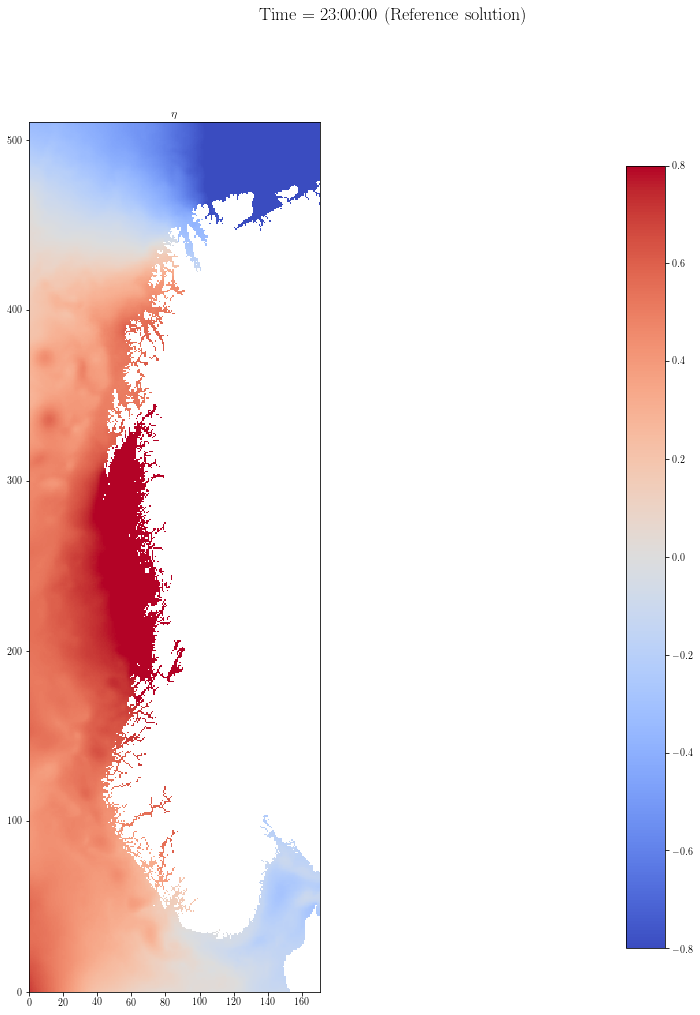

In [37]:
def refAnimation(t, movie_frames=None, create_movie=True, fig=None, save_movie=True, **kwargs):    
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))
    
    tsteps = timesteps
    if (not create_movie):
        tsteps = [tsteps[0]] + [tsteps[-1]]
        
    if movie_frames is None:
        movie_frames = len(tsteps)
        
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][tsteps, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][tsteps, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][tsteps, y0:y1, x0:x1]
        
        for timestep in range(len(tsteps)):
            hu[timestep] = hu[timestep] * (H_m + eta[timestep])
            hv[timestep] = hv[timestep] * (H_m + eta[timestep])
    except Exception as e:
        raise e
    finally:
        ncfile.close()

    
    progress = Common.ProgressPrinter(5)
    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], "Reference solution",
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy,
                              t[-1], "Reference solution",
                              **kwargs)
        return
    
    progress = Common.ProgressPrinter(5)
    
    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 
        
        k = np.searchsorted(time, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])
        
        plotSolution(fig, 
                     (1-s)*eta[j] + s*eta[k], 
                     (1-s)*hu[j]  + s*hu[k], 
                     (1-s)*hv[j]  + s*hv[k], 
                     H_m+(1-s)*eta[j] + s*eta[k], 
                     dx, dy, 
                     t_now, "Reference solution",
                     **kwargs, ax=ax, sp=sp)
        
        clear_output(wait = True)
        print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=100)
    
    if (save_movie):
        anim.save('reference.mp4')
        plt.close(fig)
        print("Saving to reference.mp4")
        return Video('reference.mp4')
    else:
        plt.close(fig)
        return anim

refAnimation(time, 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=0,
             rotate=True, 
             downsample=4)

# Run original resolution simulation

In [38]:
importlib.reload(CDKLM16)

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": nx, "ny": ny,
    "dx": dx, "dy": dy,
    "dt": 0.0,
    "g": 9.81,
    "f": f,
    "coriolis_beta": beta,
    #"r": 2.4e-3,
    #"r": 1.6e-4,
    "r": 0.0,
    "rk_order": 2
}

data_args = {"H": H_i, 
             "eta0": eta0, 
             "hu0": hu0, 
             "hv0": hv0,
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind_stress": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)

ncSimulation(sim=sim, 
             filename=casename+"original.nc",
             timesteps=time,
             interior_domain_only=False)

File complete_coast_2019_10_16/complete_coast_original.nc already exists, skipping simulation.


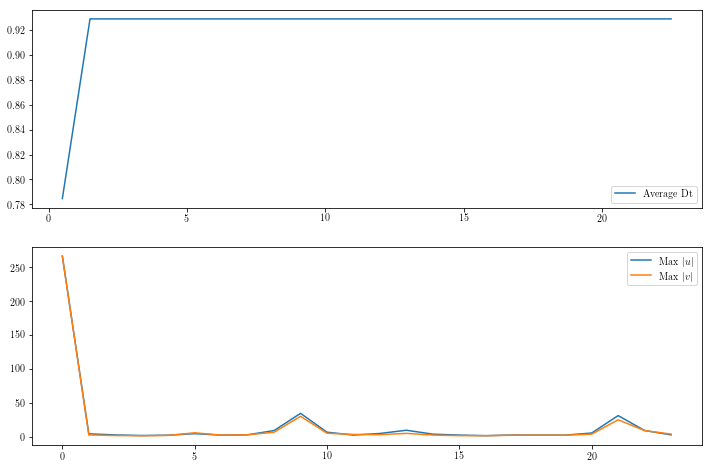

In [39]:
def plotStatistics(filename): 
    filename = os.path.join(folder, filename)
    try:
        ncfile = Dataset(filename)
        t = ncfile.variables['time'][:]
        num_iterations = ncfile.variables['num_iterations'][:]

        num_timesteps = len(t)
        max_abs_u = np.zeros(num_timesteps)
        max_abs_v = np.zeros(num_timesteps)
        
        H_m = ncfile.variables['Hm'][:,:]
        
        for i in range(num_timesteps):
            h = H_m + ncfile.variables['eta'][i,:,:]
            
            u = ncfile.variables['hu'][i,:,:] / h
            v = ncfile.variables['hv'][i,:,:] / h
            
            max_abs_u[i] = np.max(np.abs(u))
            max_abs_v[i] = np.max(np.abs(v))
            
        
    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

    plt.title("Statistics")
    plt.subplot(2,1,1)
    plt.plot(0.5*(t[1:] + t[:-1])/3600, np.diff(t)/np.diff(num_iterations), label="Average Dt")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(t/3600, max_abs_u, label="Max $|u|$")
    plt.plot(t/3600, max_abs_v, label="Max $|v|$")
    plt.legend()

plt.figure(figsize=(12,8))
plotStatistics(casename+"original.nc")

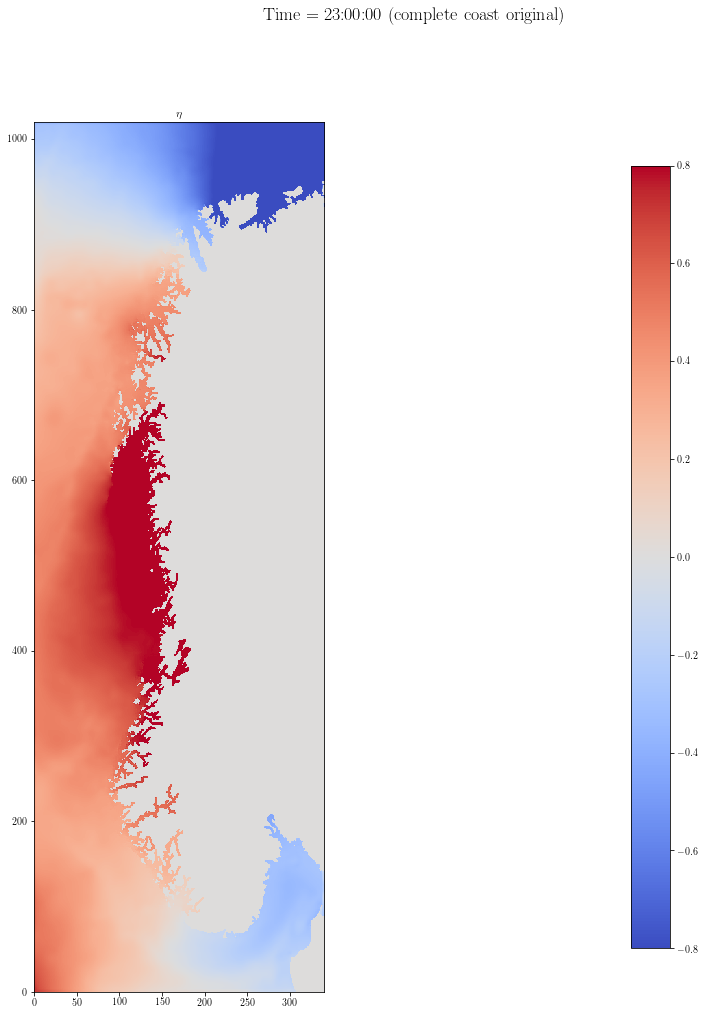

In [40]:
ncAnimation(casename+"original.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=0,
             rotate=True, 
             downsample=2)

# Simulate low-resolution

In [41]:
importlib.reload(OceanographicUtilities)

#Set scaling factor
scale = 0.5

nx_new = int((x1 - x0)*scale) - sponge_cells[1] - sponge_cells[3]
ny_new = int((y1 - y0)*scale) - sponge_cells[0] - sponge_cells[2]

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": nx_new, "ny": ny_new,
    "dx": dx/scale, "dy": dy/scale,
    "dt": 0.0,
    "g": 9.81,
    "f": f,
    "coriolis_beta": beta,
    #"r": 2.4e-3,
    #"r": 1.6e-4,
    "r": 0.0,
    "rk_order": 2
}

data_args = {"H": OceanographicUtilities.rescaleIntersections(H_i, (H_i.shape[1]-1)*scale+1, (H_i.shape[0]-1)*scale+1)[2],
             "eta0": OceanographicUtilities.rescaleMidpoints(eta0, eta0.shape[1]*scale, eta0.shape[0]*scale)[2], 
             "hu0": OceanographicUtilities.rescaleMidpoints(hu0, hu0.shape[1]*scale, hu0.shape[0]*scale)[2], 
             "hv0": OceanographicUtilities.rescaleMidpoints(hv0, hv0.shape[1]*scale, hv0.shape[0]*scale)[2],
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind_stress": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)
ncSimulation(sim=sim, 
             filename=casename+"lowres.nc",
             timesteps=time,
             interior_domain_only=False)

File complete_coast_2019_10_16/complete_coast_lowres.nc already exists, skipping simulation.


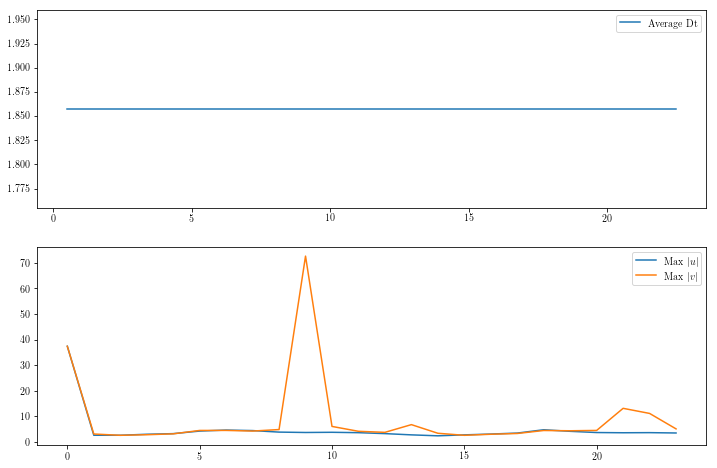

In [42]:
plt.figure(figsize=(12,8))
plotStatistics(casename+"lowres.nc")

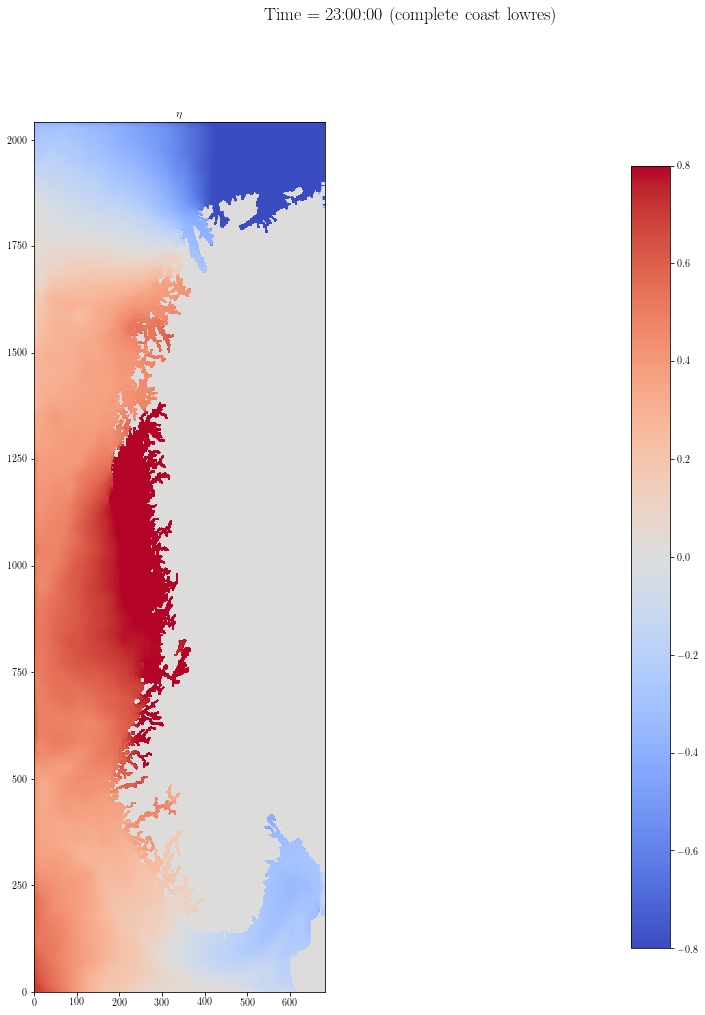

In [43]:
ncAnimation(casename+"lowres.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=0,
             rotate=True,
             downsample=1)

# Simulate high-resolution

In [44]:
#Set scaling factor
scale = 2

importlib.reload(Common)

nx_new = (x1 - x0)*scale - sponge_cells[1] - sponge_cells[3]
ny_new = (y1 - y0)*scale - sponge_cells[0] - sponge_cells[2]

print((ny_new, nx_new))

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": nx_new, "ny": ny_new,
    "dx": dx/scale, "dy": dy/scale,
    "dt": 0.0,
    "g": 9.81,
    "f": f,
    "coriolis_beta": beta,
    #"r": 2.4e-3,
    #"r": 1.6e-4,
    "r": 0.0,
    "rk_order": 2
}

data_args = {"H": OceanographicUtilities.rescaleIntersections(H_i, (H_i.shape[1]-1)*scale+1, (H_i.shape[0]-1)*scale+1)[2],
             "eta0": OceanographicUtilities.rescaleMidpoints(eta0, eta0.shape[1]*scale, eta0.shape[0]*scale)[2], 
             "hu0": OceanographicUtilities.rescaleMidpoints(hu0, hu0.shape[1]*scale, hu0.shape[0]*scale)[2], 
             "hv0": OceanographicUtilities.rescaleMidpoints(hv0, hv0.shape[1]*scale, hv0.shape[0]*scale)[2],
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind_stress": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)
ncSimulation(sim=sim, 
             filename=casename+"highres.nc",
             timesteps=time,
             interior_domain_only=False)

(1540, 4940)
File complete_coast_2019_10_16/complete_coast_highres.nc already exists, skipping simulation.


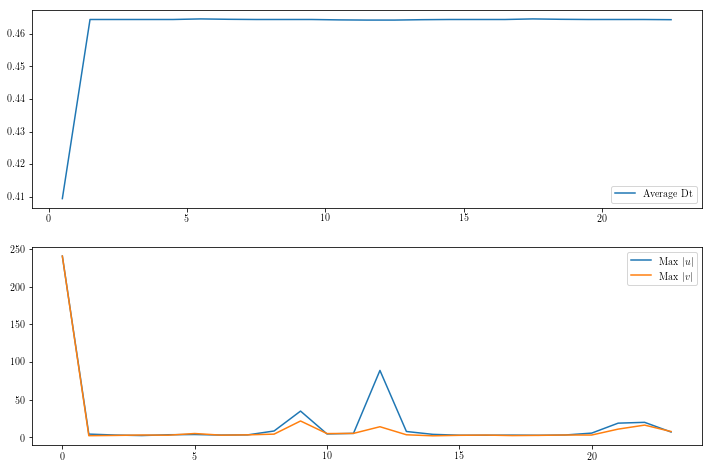

In [45]:
plt.figure(figsize=(12,8))
plotStatistics(casename+"highres.nc")

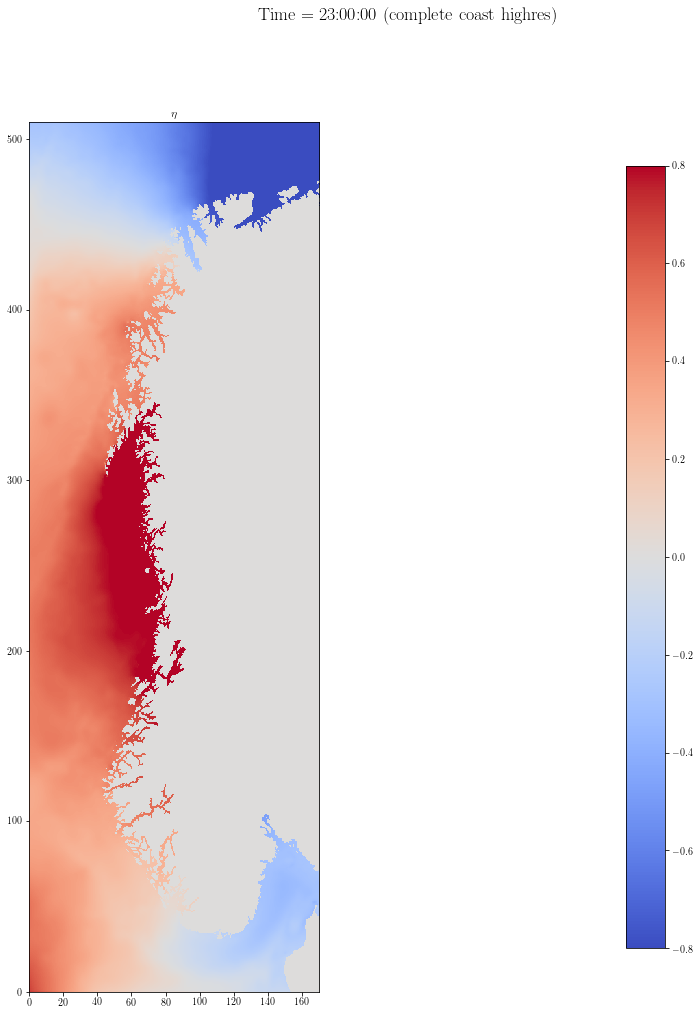

In [46]:
ncAnimation(casename+"highres.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=0,
             rotate=True,
             downsample=4)

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/modules/centos7/python/3.7.2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-6abd2c3ea3ee>", line 191, in <module>
    hour=hour, savethis=savethis)
  File "<ipython-input-47-6abd2c3ea3ee>", line 145, in plotSingleTimeStep
    save_filename=save_filename, savethis=savethis)
  File "<ipython-input-47-6abd2c3ea3ee>", line 22, in paperFig
    V.mask = H_m.mask
AttributeError: 'numpy.ndarray' object has no attribute 'mask'
Popping <31601664>
Pushing <31601664>


Info for complete_coast_2019_10_16/complete_coast_original.nc
shape Hm:  (850, 2550)
total number of cells  2167500
Dry cells, found by H_m.mask.sum():  994679
Wet cells 1172821
ratio of wet cells:  0.5410938869665514


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

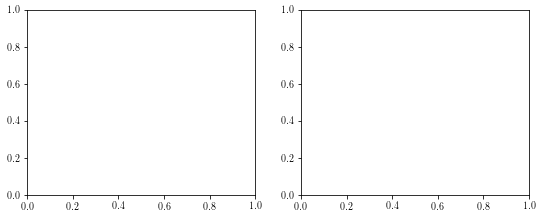

In [47]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


def paperFig(eta, hu, hv, H_m, x, y, 
             interpolation="None", title=None, figsize=(9, 3.4),
             save_filename=None, main_title=None, savethis=False):
    
    fig, axs = plt.subplots(1,2, figsize=figsize)
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    clevels= np.arange(np.floor(eta.min()*5)/5, np.ceil(eta.max()*5)/5, 0.2)
    if x0 == case1_x0:
        clevels= np.arange(np.floor(eta.min()*10)/10, np.ceil(eta.max()*10)/10, 0.1)
        
    assert(len(clevels) < 51), 'clevels contains ' + str(len(clevels)) + ' levels!!'

    extent=np.array([0, x[-1], 0, y[-1]]) / 1000
    
    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = H_m.mask
    
    # Colormaps
    eta_cmap = plt.cm.BrBG
    v_cmap=plt.cm.Oranges
    
    # Set land color
    #land_color = 'xkcd:grey green' # 'grey'
    land_color = 'grey'
    v_cmap.set_bad(land_color, alpha=1.0)
    eta_cmap.set_bad(land_color, alpha=1.0)
    
    # Specifying hard vlims
    eta_max = 2.1
    v_max = 0.42
    
    fontsize = 18
    if casename == 'complete_coast_':
        fontsize = 14
        main_title = main_title.replace('resolution', 'res.')
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=-eta_max, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, "$\eta$ [m]")
    eta_cs = axs[0].contour(eta, clevels, colors='k', origin='lower', corner_mask=True, linestyles='dashed', extent=extent)
    axs[0].clabel(eta_cs, eta_cs.levels, inline=True, fontsize=7, fmt='%1.1f', use_clabeltext=True)
    
    hv_im = axs[1].imshow(V, interpolation=interpolation, origin='lower',
                          vmin=0, vmax=v_max, extent=extent, cmap=v_cmap)
    addColorbar(axs[1], hv_im, "particle velocity [m/s]")
    
    
    
    if main_title is not None:
        axs[0].set_ylabel(main_title, labelpad=3, fontsize=fontsize)
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    
    if save_filename is not None and savethis:
        print(save_filename)
        fig.savefig(os.path.join(folder, save_filename + ".png"), bbox_inches='tight')
        fig.savefig(os.path.join(folder, save_filename + ".pdf"), bbox_inches='tight')
        plt.close()
        
        
def plotSingleReferenceStep(source_url, hour=-1, savethis=False):
    
    hour = hour%24
    save_filename = casename+'norkyst800_'+str(hour).zfill(2)
    title = 'NorKyst800 ' + str(hour)
    main_title = 'NorKyst800'
    
    ncfile = None
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][hour, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][hour, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][hour, y0:y1, x0:x1]
        
        x = ncfile.variables['X'][x0:x1]
        y = ncfile.variables['Y'][y0:y1]
        x = x - x[0]
        y = y - y[0]
        
        hu = hu * (H_m + eta)
        hv = hv * (H_m + eta)
        
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
    H_m.mask = eta.mask
    paperFig(eta, hu, hv, H_m, x, y,  title=title, main_title=main_title,
             save_filename=save_filename, savethis=savethis)
    
def plotSingleTimeStep(filename, main_title, hour=-1, savethis=False):
    
    hour = hour%24
    save_filename = filename.replace('.nc', '_'+str(hour).zfill(2))
    title = filename.replace('_', ' ').replace('.nc', ' ') + str(hour)
    filename = os.path.join(folder, filename)
    
    ncfile = None
    try:
        ncfile = Dataset(filename)

        x = ncfile.variables['x'][:]
        y = ncfile.variables['y'][:]
        t = ncfile.variables['time'][hour]

        H_m = ncfile.variables['Hm'][:,:]
        eta = ncfile.variables['eta'][hour,:,:]
        hu = ncfile.variables['hu'][hour,:,:]
        hv = ncfile.variables['hv'][hour,:,:]
    except Exception as e:
        raise e
    finally:
        if ncfile is not None:
            ncfile.close()
    
    if hour == 0:
        print('Info for ' + filename)
        print("shape Hm: ", H_m.shape)
        num_cells = H_m.shape[0]*H_m.shape[1]
        print("total number of cells ", num_cells)
        print("Dry cells, found by H_m.mask.sum(): ", H_m.mask.sum())
        print("Wet cells", num_cells - H_m.mask.sum())
        print("ratio of wet cells: ", str((num_cells - H_m.mask.sum())/num_cells))

    eta.mask = H_m.mask
    hu.mask = H_m.mask
    hv.mask = H_m.mask

    paperFig(eta, hu, hv, H_m, x, y,  title=title, main_title=main_title,
             save_filename=save_filename, savethis=savethis)
        
def randomtesting():
    test_ma = hu[:,:].copy()
    print(type(test_ma))
    fig = plt.figure(figsize=(6,4))
    cmap = plt.cm.viridis
    cmap.set_bad('white',1.)
    
    test_ma.mask = H_m.mask
    test_ma.data[test_ma.mask]=300

    
    plt.imshow(test_ma, origin='lower', cmap=cmap)
    plt.colorbar()
    print(test_ma.mask)
    print(H_m.min(), H_m.max(), np.sum(H_m.mask), H_m.shape[0]*H_m.shape[1])
    print(np.sum(test_ma.mask), test_ma.shape[0]*test_ma.shape[1])
    
    
    ### Test with contour plot for eta:
    fig = plt.figure(figsize=(6,4))
    
    eta_max = np.max(np.abs(eta))
    levels= np.arange(-eta_max, eta_max, 0.2)


    plt.imshow(eta, cmap='BrBG', origin='lower', vmin=-eta_max, vmax=eta_max)
    plt.contour(eta, levels, colors='k', origin='lower', corner_mask=True, linestyles='dashed')
    
    ### Test with contour plot for eta:
    fig = plt.figure(figsize=(6,4))
    
    eta_max = np.max(np.abs(eta))
    levels= np.arange(-np.ceil(eta_max), np.ceil(eta_max), 0.2)


    plt.imshow(eta, cmap='BrBG', origin='lower', vmin=-eta_max, vmax=eta_max)
    CS = plt.contour(eta, levels, colors='k', origin='lower', corner_mask=False, linestyles='dashed')
    plt.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%1.1f')

    
hour = 23
savethis = True
for hour in range(0,24, 6):
    plotSingleTimeStep(casename+'original.nc', 'Original resolution', 
                       hour=hour, savethis=savethis)
    plotSingleTimeStep(casename+'highres.nc', 'High resolution',
                       hour=hour, savethis=savethis)
    plotSingleTimeStep(casename+'lowres.nc',  'Low resolution',
                       hour=hour, savethis=savethis)
    plotSingleReferenceStep(source_url, 
                            hour=hour, savethis=savethis)

In [ ]:
def plotAllStatistics(filenames, labels, single_figs=False):
    
    patterns = [':', '--', '-.']
    
    assert(len(filenames) == len(labels))

    if not single_figs:
        plt.figure(figsize=(6,2))

    for i in range(len(filenames)):
        filename = filenames[i]
        label = labels[i]
        pattern = patterns[i]
        
        if single_figs:
            plt.figure(figsize=(12,4))
    
        filename = os.path.join(folder, filename)
        try:
            ncfile = Dataset(filename)
            t = ncfile.variables['time'][:]
            num_iterations = ncfile.variables['num_iterations'][:]

            num_timesteps = len(t)
            max_abs_u = np.zeros(num_timesteps)
            max_abs_v = np.zeros(num_timesteps)

            H_m = ncfile.variables['Hm'][:,:]

            for i in range(num_timesteps):
                h = H_m + ncfile.variables['eta'][i,:,:]

                u = ncfile.variables['hu'][i,:,:] / h
                v = ncfile.variables['hv'][i,:,:] / h

                max_abs_u[i] = np.max(np.abs(u))
                max_abs_v[i] = np.max(np.abs(v))


        except Exception as e:
            print("Something went wrong:" + str(e))
            raise e
        finally:
            ncfile.close()

        #plt.title("Statistics")
        #plt.subplot(2,1,1)
        plt.plot(0.5*(t[1:] + t[:-1])/3600, np.diff(t)/np.diff(num_iterations), 
                 pattern, label=label)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", 
               mode='expand', ncol=3)
    plt.ylim([0, 2])
    plt.grid()
    plt.xlabel('Time [hours]')
    plt.ylabel('$\Delta t$ [s]')
    
    plt.savefig(os.path.join(folder, 'adaptive_dt.pdf'), bbox_inches='tight')
    
    #plt.subplot(2,1,2)
    #plt.plot(t/3600, max_abs_u, label="Max $|u|$")
    #plt.plot(t/3600, max_abs_v, label="Max $|v|$")
    #plt.legend()
        
filenames = [casename+"original.nc",
             casename+"highres.nc",
             casename+"lowres.nc"]
labels = ['Original resolution', 
          'High resolution',
          'Low resolution']


plotAllStatistics(filenames, labels, single_figs=0)